In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/envs/work/lib/python3.4/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'tsfc', 
            'pressure_reference_high',
            'temperature_reference_high', 
            'pressure_reference_low', 
            'temperature_reference_low',
            'ighigh', 
            'ng', 
            'absth',
            'wgt']


def pattern_assign(name):
    return ''' 
    parameter .* :: .* ({} .* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/]+ {}[^,] [^/]+ / [^/]+ /)
    '''.format(name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu',
                          'radiation',
                          'crd/LW/examples',
                          'separate_g_groups/study__lblnew_g1_threshold',
                          'n2o',
                          'band07_wn_1215_1380',
                          'P_500_T_250_min_2.22e-20_max_1.35e-19_ng_2__P_1_T_250_ng_2_dlogN_uniform_absth3x8',
                          'wgt_.9_.7_.6_.6',
                          'subarctic_winter__dv_.005')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu',
                          'radiation',
                          'crd/LW/examples',
                          'separate_g_groups/study__lblnew_g1_threshold',
                          'n2o',
                          'band07_wn_1215_1380',
                          'P_500_T_250_min_2.22e-20_max_1.35e-19_ng_2__P_1_T_250_ng_2_dlogN_uniform_absth3x8',
                          'wgt_.9_.7_.6_.6',
                          'subarctic_winter__dv_.005')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1')
fig.ggroups = list(range(1, 4 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-4, 50)

In [8]:
fig2 = analysis.fig_fluxcoolr('fig2',
                              ggroups=list(range(1, 4 + 1)),
                              vartypes=['cooling rate'])
fig2.vars_plot['cooling rate'] = ['coolrg']
fig2.colors['flug'] = 'darkred'
fig2.colors['fnetg'] = 'lightcoral'
fig2.colors['coolrg'] = 'blue'
fig2.varlims_from_indexrange['linear'] = (50, 1050)
fig2.varlims_from_indexrange['log'] = (1e-4, 50)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = np.sort(
    xr.concat(
        [crd.data['flux'].coords['pressure'].isel(pressure=[0, -1]),
         crd.data['flux'].coords['pressure'].sel(pressure=300, 
                                                 method='nearest')],
        dim='pressure'))

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])
        
table_flux.at_pressures = np.sort(
    xr.concat(
        [crd.data['flux'].coords['pressure'].isel(pressure=[0, -1]),
         crd.data['flux'].coords['pressure'].sel(pressure=300, 
                                                 method='nearest')],
        dim='pressure'))

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
# print some input parameters

with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc = 257.0

pressure_reference_high = 1.

temperature_reference_high = 250.

pressure_reference_low = 500.

temperature_reference_low = 250.

ighigh = 2

ngas = 6      

ng = 4

data absth(:, 1)
     &     /1, 1, 1.0706296e-18, 1/

data absth(:, 2)
     &     /2.22e-20,  1.35e-19, 1, 1/

data wgt
     &     /.9, .7, .6, .6/

include 'saw75.pro'


In [13]:
fig.display_hrefanchor()

In [14]:
fig2.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()
table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: flux, cooling rate g-group 1

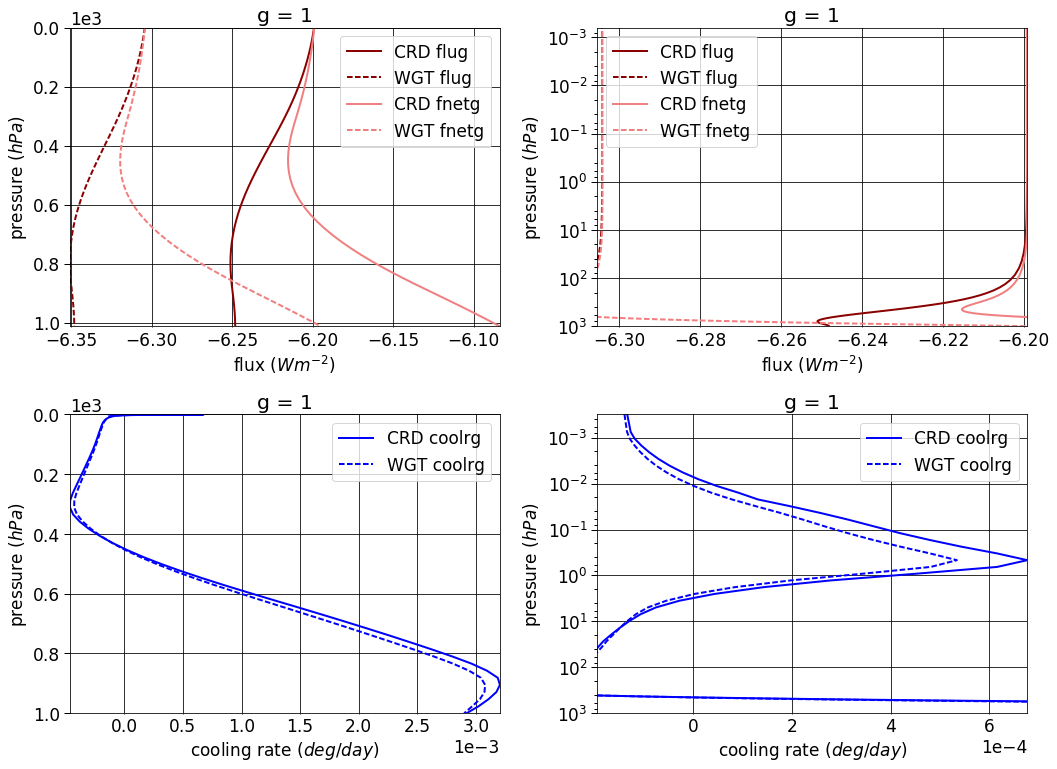

# Figure: flux, cooling rate g-group 2

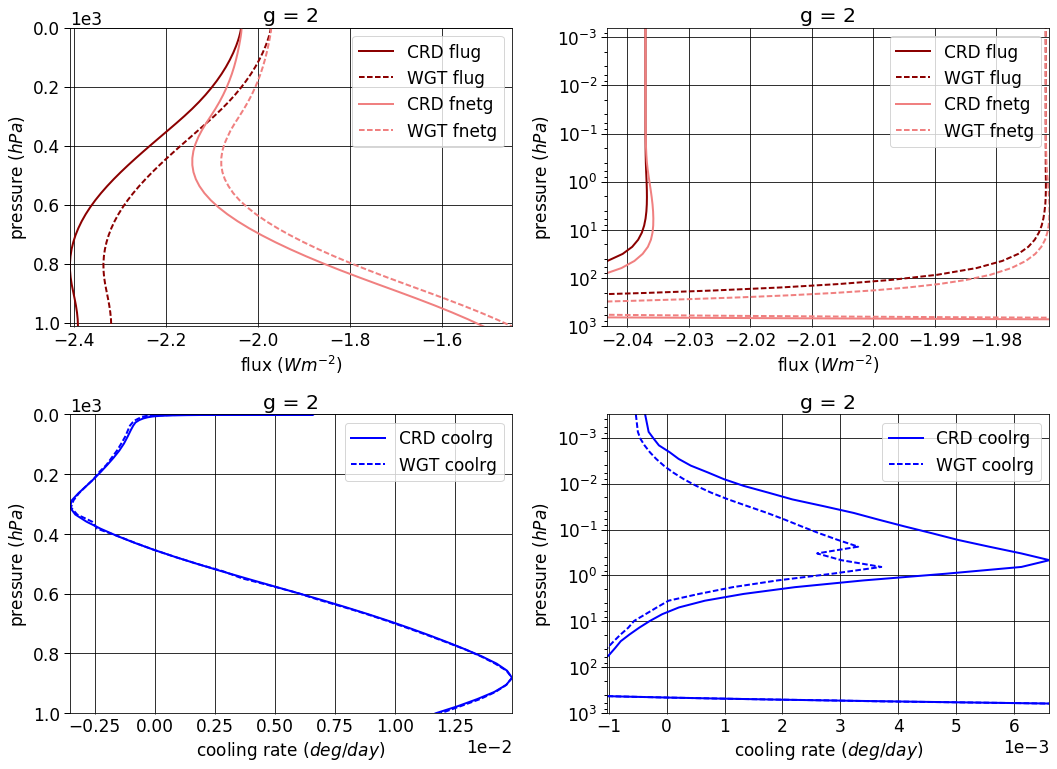

# Figure: flux, cooling rate g-group 3

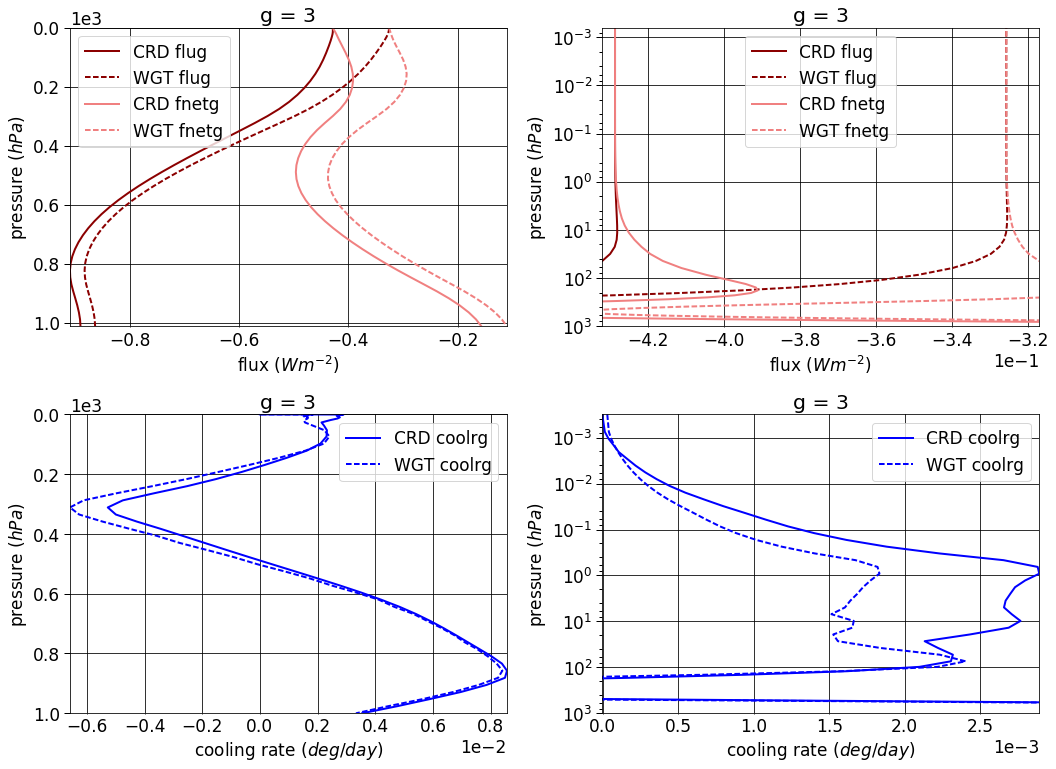

# Figure: flux, cooling rate g-group 4

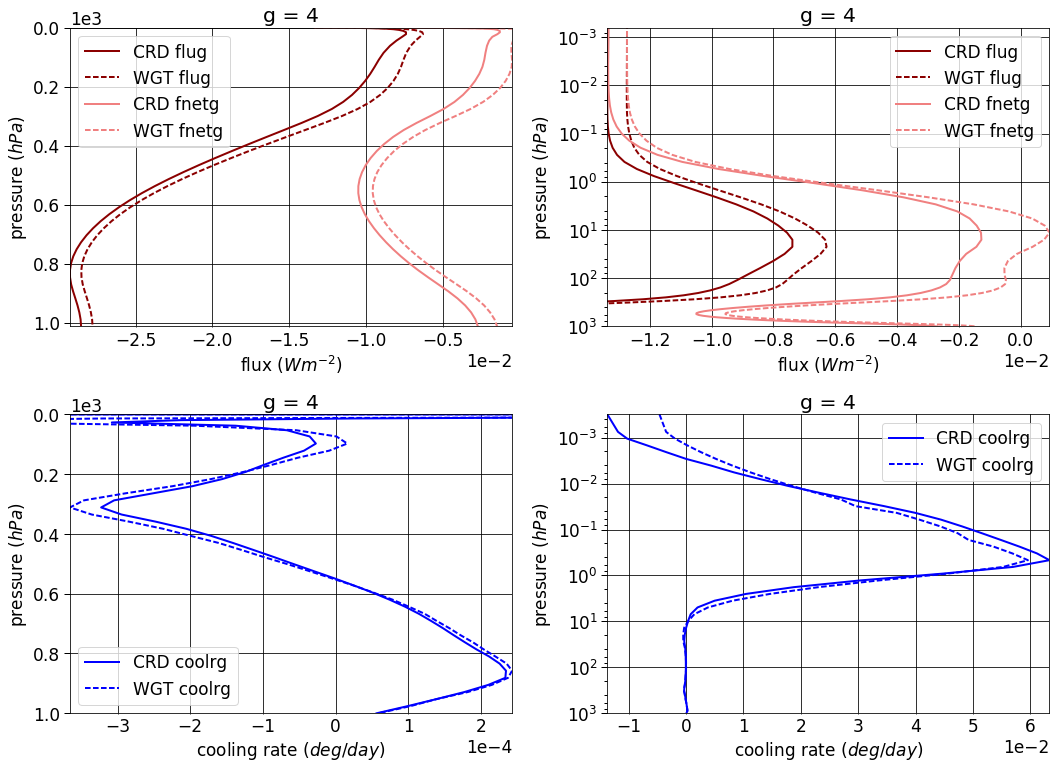

# Figure: flux, cooling rate g-group total

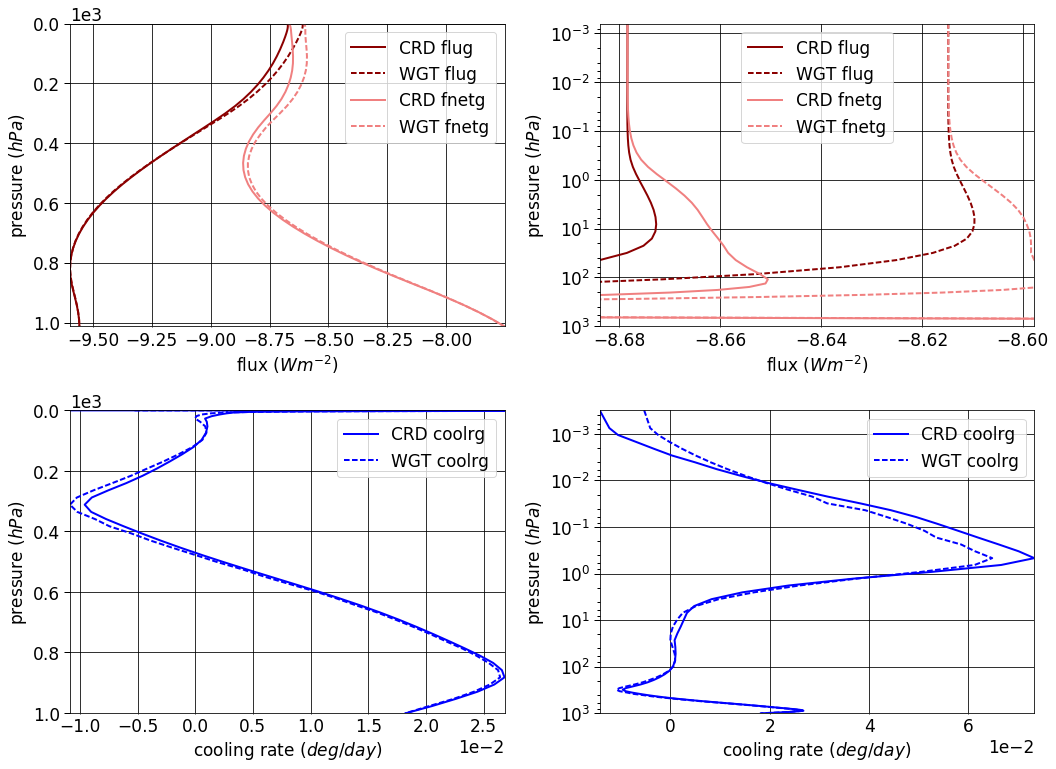

In [19]:
matplotlib.rcParams.update({'font.size': 17,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


# Figure: cooling rate g-group 1

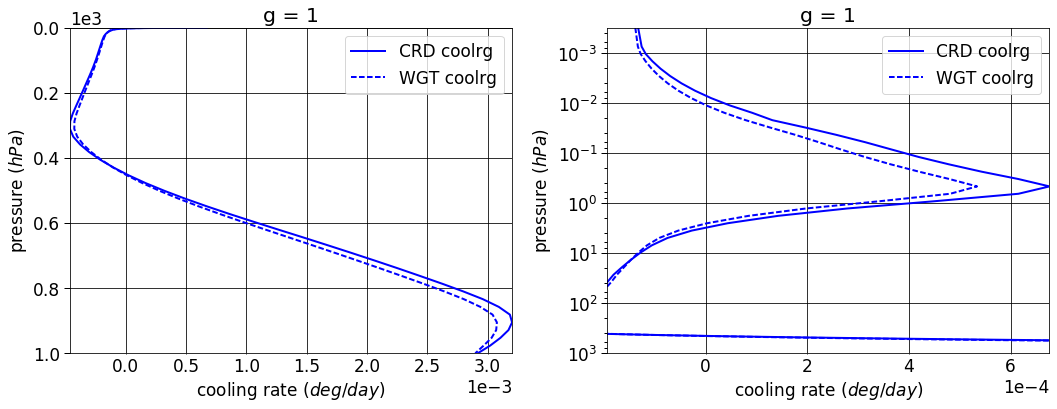

# Figure: cooling rate g-group 2

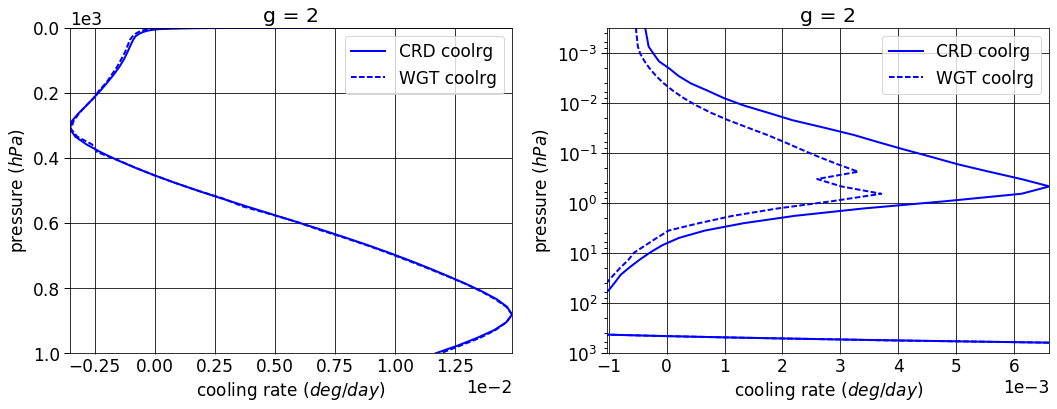

# Figure: cooling rate g-group 3

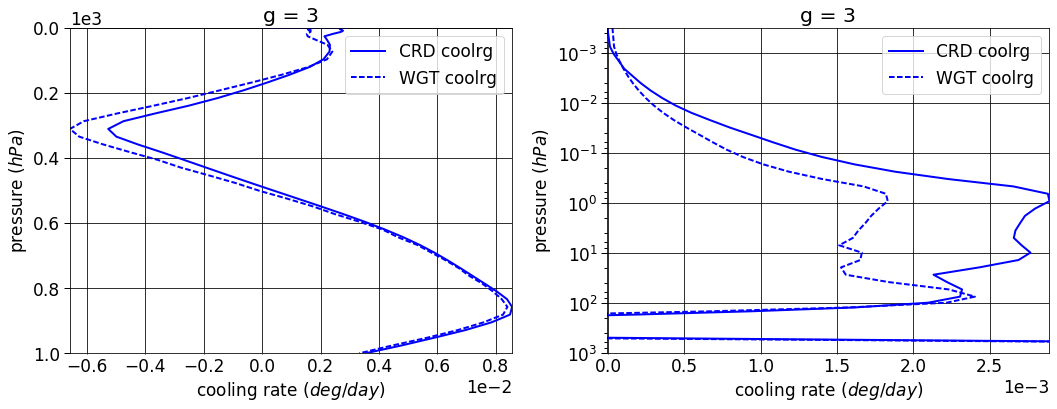

# Figure: cooling rate g-group 4

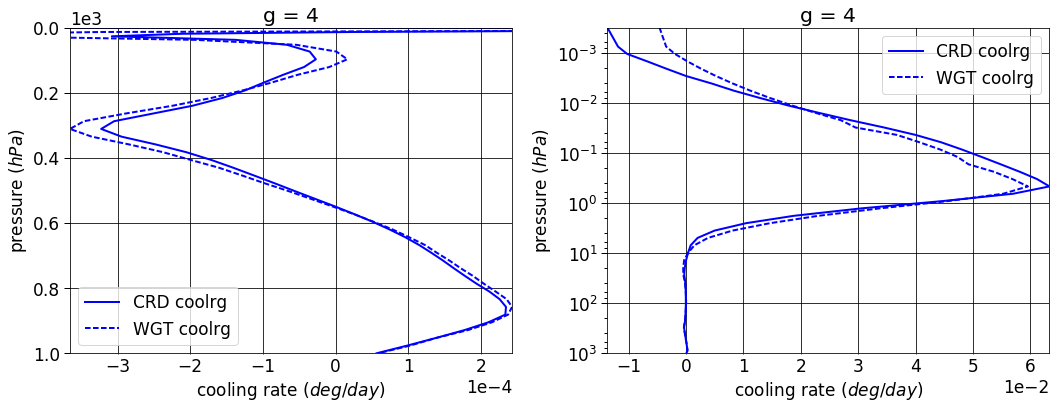

# Figure: cooling rate g-group total

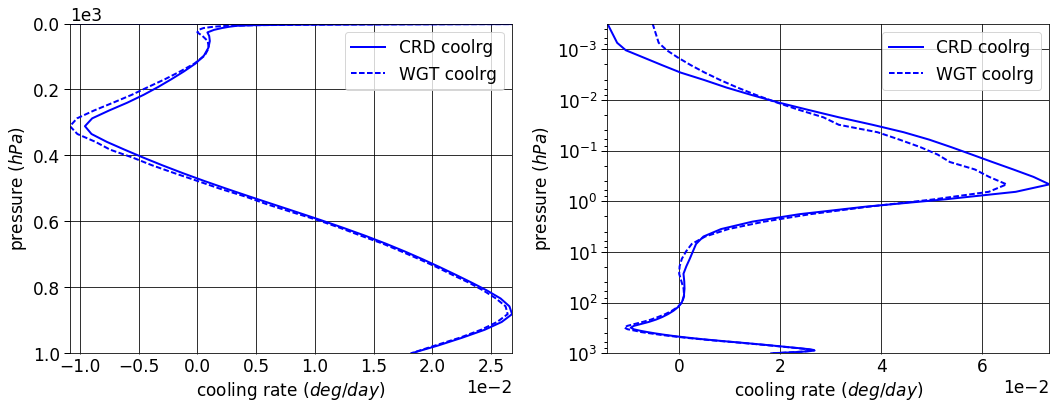

In [20]:
matplotlib.rcParams.update({'font.size': 17,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 
fig2.plot(analysis)

In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -6.199257  0.000000 -6.199257
  299.75   46    -6.216912  0.006915 -6.209998
  1013.00  76    -6.248110  0.164279 -6.083831
2 0.00     1     -2.037022  0.000000 -2.037022
  299.75   46    -2.159608  0.057336 -2.102273
  1013.00  76    -2.391149  0.881434 -1.509715
3 0.00     1     -0.428767  0.000000 -0.428767
  299.75   46    -0.547532  0.119469 -0.428062
  1013.00  76    -0.890215  0.734102 -0.156112
4 0.00     1     -0.013345  0.000000 -0.013345
  299.75   46    -0.013131  0.007334 -0.005797
  1013.00  76    -0.028553  0.025846 -0.002708


WGT


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -6.304284  0.000000 -6.304284
  299.75   46    -6.320337  0.005861 -6.314477
  1013.00  76    -6.347978  0.153086 -6.194892
2 0.00     1     -1.971968  0.000000 -1.971968
  299.75   46    -2.094640  0.054620 -2.040021
  1013.00  76    -2.318835  0.871321 -1.447515
3 0.00     1     -0.325798  0.000000 -0.325798
  299.75   46    -0.497669  0.150701 -0.346968
  1013.00  76    -0.863408  0.753980 -0.109428
4 0.00     1     -0.012738  0.000000 -0.012738
  299.75   46    -0.011551  0.007396 -0.004155
  1013.00  76    -0.027805  0.026351 -0.001454


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -0.105028  0.000000 -0.105028
  299.75   46    -0.103425 -0.001054 -0.104479
  1013.00  76    -0.099868 -0.011193 -0.111061
2 0.00     1      0.065053  0.000000  0.065053
  299.75   46     0.064968 -0.002716  0.062252
  1013.00  76     0.072314 -0.010113  0.062201
3 0.00     1      0.102969  0.000000  0.102969
  299.75   46     0.049863  0.031232  0.081094
  1013.00  76     0.026806  0.019878  0.046684
4 0.00     1      0.000607  0.000000  0.000607
  299.75   46     0.001580  0.000062  0.001642
  1013.00  76     0.000748  0.000505  0.001253

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000133
  1001.112500 75     0.002918
2 0.000312    1     -0.000374
  1001.112500 75     0.011702
3 0.000312    1     -0.000005
  1001.112500 75     0.003536
4 0.000312    1     -0.013704
  1001.112500 75     0.000056


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.000139
  1001.112500 75     0.002898
2 0.000312    1     -0.000535
  1001.112500 75     0.011908
3 0.000312    1      0.000028
  1001.112500 75     0.003323
4 0.000312    1     -0.004623
  1001.112500 75     0.000059


WGT - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000006
  1001.112500 75    -0.000021
2 0.000312    1     -0.000160
  1001.112500 75     0.000206
3 0.000312    1      0.000033
  1001.112500 75    -0.000212
4 0.000312    1      0.009081
  1001.112500 75     0.000002

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-8.678390,0.000000,-8.678390
299.75,46,-8.937183,0.191054,-8.746129
1013.00,76,-9.558027,1.805660,-7.752367



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-8.614788,0.000000,-8.614788
299.75,46,-8.924198,0.218578,-8.705621
1013.00,76,-9.558027,1.804737,-7.753289



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,6.360233e-02,0.000000,0.063602
299.75,46,1.298513e-02,0.027524,0.040509
1013.00,76,1.060000e-07,-0.000923,-0.000923


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.014216
1001.112500,75,0.018213



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.005268
1001.112500,75,0.018188



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.008949
1001.112500,75,-0.000025


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.664152,0.653402
2,0.242606,0.250392
3,0.090333,0.093217
4,0.002909,0.002989


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.220000e-20
2,1.350000e-19
3,1.070630e-18


In [24]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')